<a href="https://colab.research.google.com/github/agamsiingh/DSD/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install soundata librosa torch tensorflow

In [3]:
import soundata
dataset = soundata.initialize('urbansound8k', data_home='.')  # Use current directory
dataset.download()  # Download UrbanSound8K (∼6–7 GB) from Zenodo

5.61GB [28:08, 3.57MB/s]                            
1.15MB [00:02, 458kB/s]                            


In [4]:
ids = dataset.clip_ids                      # list of all clip IDs
clip = dataset.clip(ids[0])                 # load the first clip
print(clip.class_label, clip.fold)          # e.g. "siren", fold number
audio, sr = clip.audio                      # load audio (numpy array, sampling rate)


children_playing 1


In [9]:
# Preprocess: normalize amplitude
audio = audio.astype(np.float32)
audio = audio / np.max(np.abs(audio))

# -- Pitch Estimation (Doppler) --
# Estimate fundamental frequency (Hz) using librosa YIN
f0 = librosa.yin(audio, fmin=50, fmax=2000, sr=sr)
f0_mean = f0.mean()
print(f"Fundamental frequency (original): {f0_mean:.1f} Hz")

# Simulate Doppler: artificially raise pitch by 4 semitones (approaching source)
# Ensure mono audio
if audio.ndim > 1:
    audio = librosa.to_mono(audio)

# Pitch shift properly with keyword args
audio_shifted = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=4)

f_shift = librosa.yin(audio_shifted, fmin=50, fmax=2000, sr=sr).mean()
print(f"Fundamental frequency (shifted): {f_shift:.1f} Hz")

# Estimate relative velocity: v = c * |(f_s/f_o - 1)|
c = 343.0  # speed of sound in air (m/s)
if f_shift > f0_mean:
    v_est = c * (1 - f0_mean / f_shift)   # approaching formula
else:
    v_est = c * (f0_mean / f_shift - 1)   # receding formula
print(f"Estimated relative velocity: {abs(v_est):.1f} m/s")

# -- Feature Extraction with PyTorch/TensorFlow --
# Compute STFT with PyTorch
audio_tensor = torch.from_numpy(audio)
stft_torch = torch.stft(audio_tensor, n_fft=1024, hop_length=512, return_complex=True)
print("STFT (PyTorch) shape:", stft_torch.shape)

# Compute STFT with TensorFlow
audio_tf = tf.constant(audio, dtype=tf.float32)
stft_tf = tf.signal.stft(audio_tf, frame_length=1024, frame_step=512)
mag_tf = tf.abs(stft_tf)
print("STFT (TensorFlow) shape:", mag_tf.shape)

Fundamental frequency (original): 1285.0 Hz
Fundamental frequency (shifted): 1620.3 Hz
Estimated relative velocity: 71.0 m/s
STFT (PyTorch) shape: torch.Size([513, 345])


/usr/local/lib/python3.11/dist-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


STFT (TensorFlow) shape: (343, 513)


/tmp/ipython-input-10-816745549.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


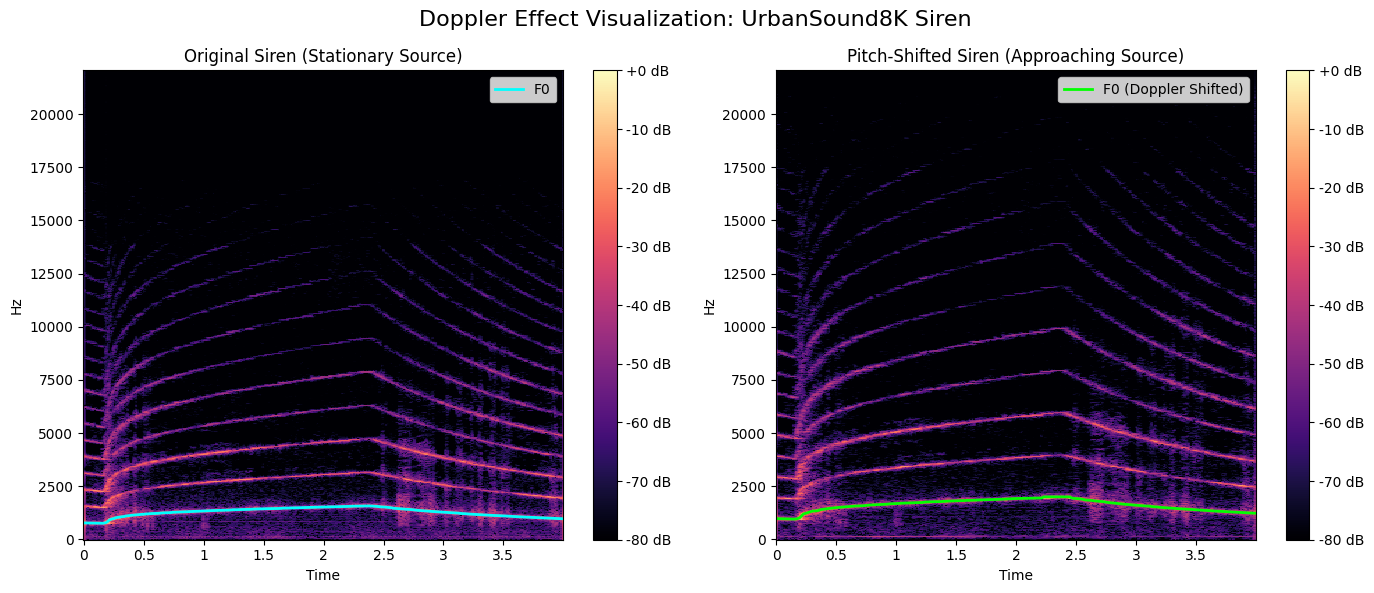

In [10]:
import soundata
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load UrbanSound8K
dataset = soundata.initialize('urbansound8k', data_home='.')
# dataset.download()  # Uncomment if not already downloaded

# Select a clip with class 'siren'
siren_clip = None
for cid in dataset.clip_ids:
    clip = dataset.clip(cid)
    if clip.class_label == 'siren':
        siren_clip = clip
        break

audio, sr = siren_clip.audio

# Convert stereo to mono if needed
if audio.ndim > 1:
    audio = librosa.to_mono(audio)

# Normalize
audio = audio.astype(np.float32)
audio = audio / np.max(np.abs(audio))

# Pitch shift upward by 4 semitones (simulate approaching source)
audio_shifted = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=4)

# Compute STFT spectrograms
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
S_shifted = librosa.amplitude_to_db(np.abs(librosa.stft(audio_shifted)), ref=np.max)

# Estimate fundamental frequency (F0) curves
f0_orig = librosa.yin(audio, fmin=50, fmax=2000, sr=sr)
f0_shifted = librosa.yin(audio_shifted, fmin=50, fmax=2000, sr=sr)
times = librosa.times_like(f0_orig, sr=sr)

# Plot side-by-side spectrograms
plt.figure(figsize=(14, 6))

# Original
plt.subplot(1, 2, 1)
librosa.display.specshow(S_orig, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.plot(times, f0_orig, color='cyan', linewidth=2, label='F0')
plt.title("Original Siren (Stationary Source)")
plt.colorbar(format='%+2.0f dB')
plt.legend()

# Shifted
plt.subplot(1, 2, 2)
librosa.display.specshow(S_shifted, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.plot(times, f0_shifted, color='lime', linewidth=2, label='F0 (Doppler Shifted)')
plt.title("Pitch-Shifted Siren (Approaching Source)")
plt.colorbar(format='%+2.0f dB')
plt.legend()

plt.suptitle("Doppler Effect Visualization: UrbanSound8K Siren", fontsize=16)
plt.tight_layout()
plt.show()
